In [1]:
import re
import cv2
import time
import json
import numba
import faiss
import hashlib
import requests
import itertools
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from absl import logging
from numba import vectorize
import matplotlib.pyplot as plt
from sklearn import metrics as sk_metrics
from alive_progress import alive_bar
from notifier import Notifier, notify
from tensorflow.keras import mixed_precision
from keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from utils.tf_functions import AnimeClassifier
import os
import shutil
import warnings
import pandas as pd
import random as rd
import pickle as pkl
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [2]:
SEED = 42
SIZE_IMG = 224 #224#224#416
UNITS = 2048 #2048 1024 128 256 512-seq
MAX_CLASS = 32 #1024 32 16 8

DATASET_PATH = './data/animes'
DATASET_FACES_PATH = './data/faces'
DATASET_FACE_FOLDER = './data/moeimouto-faces'
CLASS_ARRAY_PATH = f'./data/class_array_{MAX_CLASS}.pkl'
CLASS_ARRAY_FACES_PATH = f'./data/class_array_faces_{MAX_CLASS}.pkl'
CLASS_ARRAY_VEC_PATH = f'./data/class_array_vec_{MAX_CLASS}.pkl'

DATASET_JSON_PATH = './data/anime_data.json'

AMOUNT_TABLE_PATH = './data/anime_amount.pkl'
AMOUNT_FACES_TABLE_PATH = './data/faces_amount.pkl'

DATASET_JSON_RANK = './data/anime_rank.json'

TFRECORD_PATH = f'./data/anime_data_{MAX_CLASS}.tfrecord'
TFRECORD_FACES_PATH = f'./data/anime_faces_data_{MAX_CLASS}.tfrecord'

TG_ID = "293701727"
TG_TOKEN = "1878628343:AAEFVRsqDz63ycmaLOFS7gvsG969wdAsJ0w"
WEBHOOK_URL = "https://discord.com/api/webhooks/796406472459288616/PAkiGGwqe0_PwtBxXYQvOzbk78B4RQP6VWRkvpBtw6Av0sc_mDa3saaIlwVPFjOIeIbt"

#seed random seed to 42 for reproducibility
rd.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
warnings.filterwarnings('ignore')

mixed_precision.set_global_policy('mixed_float16')

if True:
  #DATASET_PATH = DATASET_FACES_PATH
  CLASS_ARRAY_PATH = CLASS_ARRAY_FACES_PATH
  TFRECORD_PATH = TFRECORD_FACES_PATH
  AMOUNT_TABLE_PATH = AMOUNT_FACES_TABLE_PATH

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Ti, compute capability 8.6


### Dataset anime

In [ ]:
def dowload_image(url, anime_name, idx):
  #download image from url
  file_path = f'./data/animes/{anime_name}____{idx}.jpg' 
  if os.path.exists(file_path):
    return

  img_data = requests.get(url).content
  with open(file_path, 'wb') as handler:
    handler.write(img_data)

@notify(
  chat_id=TG_ID,
  api_token=TG_TOKEN,
  title='Anime images',
  msg='Finished downloading anime images'
)
def get_images(data):
  #with alive_bar(len(data)) as bar:
  for idx_a, anime_name in enumerate(data):
    urls = data[anime_name]
    for idx, url in enumerate(urls):
      if idx >= 400:
        break
      name_clean = re.sub(r'_+', r'_', re.sub(r'[\W\s]', r'_', anime_name))
      try:
        dowload_image(url['image'], name_clean, idx)
      except Exception as e:
        print(f'Error on download image {idx + 1} of {anime_name}')
        pass
    #bar()
    print(f'Progress: {idx_a + 1}/{len(data)} - {round((idx_a + 1)/len(data)*100, 2)}%')

def get_classes_anime(path):
  classes = set()
  for filename in os.listdir(path):
    class_name, _ = filename.split('____')
    classes.add(class_name)
  return list(classes)

def wait_for_it(driver, xpath, timeout=3):
  try:
    return WebDriverWait(driver, timeout).until(
        EC.presence_of_element_located((By.XPATH, xpath))
    )
  except Exception as e:
    return None

def iter_post(driver):
  anime_data = []

  xpath_next = '//a[@class="next_page"]'
  next_button = True

  while next_button is not None:
    if len(anime_data) > 400:
      break
    ul_element = wait_for_it(driver, '//ul[@id="post-list-posts"]')
    if ul_element is None:
      next_button = wait_for_it(driver, xpath_next)
      if next_button is not None:
        next_button.click()
        time.sleep(1)
      continue
    for i, li_element in enumerate(ul_element.find_elements(By.TAG_NAME, 'li')):
      a_video = li_element.find_element(By.XPATH, './a').get_attribute('href')
      a_image = li_element.find_element(By.XPATH, './div/a/img').get_attribute('src')
      anime_data.append({
        'video': a_video,
        'image': a_image
      })
    next_button = wait_for_it(driver, xpath_next)
    if next_button is not None:
      next_button.click()
      time.sleep(rd.randint(1, 2))
  return anime_data

def get_images_links(url, driver, anime_name):
  url_search = url + anime_name
  driver.get(url_search)
  return iter_post(driver)

def get_names(driver):
  names = []
  xpath_next = '//a[@class="next_page"]'
  next_button = wait_for_it(driver, xpath_next)
  
  while next_button is not None:
    for tr_element in driver.find_elements(By.XPATH, '//table[@class="highlightable"]/tbody/tr'):
      try:
        amount_post = tr_element.find_element(By.XPATH, './td[1]').text
        amount_post = int(amount_post)
        if amount_post >= 10:
          a_name = tr_element.find_element(By.XPATH, './td[2]/a[2]' ).text
          names.append(a_name)
      except Exception as e:
        print(e)
        pass
    next_button.click()
    time.sleep(rd.randint(1, 2))
    next_button = wait_for_it(driver, xpath_next)
  return names

def get_score(anime_name, driver):
  url_search = f'https://myanimelist.net/anime.php?cat=anime&q={anime_name}'
  driver.get(url_search)
  score = 0
  for filename in os.listdir(path):
    class_name, _ = filename.split('____')
    score += 1
  return score

def relevant_anime(anime_name, df_anime, amount_table, threshold=350, rank=True):
  
  if amount_table.get(anime_name, 0) <= threshold:
    return False

  if not rank:
    return True

  anime_name = re.sub(r'_', r' ', anime_name)
  df_result = df_anime[df_anime['name'].str.contains(anime_name)]

  if df_result.empty:
    anime_name = ' '.join(anime_name.split(' ')[:3])
    df_result = df_anime[df_anime['name'].str.contains(anime_name)]
  return not df_result.empty

def amount_anime_table(datapath):
  dic = {}
  for filename in os.listdir(datapath):
    class_name, _ = filename.split('____')
    dic[class_name] = dic.get(class_name, 0) + 1
  return dic

def detect(filename, cascade_file):
  if not os.path.isfile(cascade_file):
    raise RuntimeError("%s: not found" % cascade_file)

  cascade = cv2.CascadeClassifier(cascade_file)
  image = cv2.imread(filename, cv2.IMREAD_COLOR)
  #src = cv2.cuda_GpuMat()
  #src.upload(image)

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.equalizeHist(gray)

  faces = cascade.detectMultiScale(
    gray,
    scaleFactor = 1.1,
    minNeighbors = 5,
    minSize = (24, 24)
  )

  new_images = []
  for (x, y, w, h) in faces:
    new_images.append(image[y:y+h, x:x+w])
  #clahe = cv2.cuda.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
  #dst = clahe.apply(src, cv2.cuda_Stream.Null())
  #result = dst.download()
  return new_images

def extract_faces(datapath):
  faces_amount = 0
  for filename in os.listdir(datapath):
    class_name, _ = filename.split('____')
    new_images = []
    try:
      new_images = detect(datapath + '/' + filename, './data/haar/lbpcascade_animeface.xml')
    except Exception as e:
      print(e)
      pass
    if len(new_images) > 0:
      for idx, img in enumerate(new_images):
        new_face_name = f'./data/faces/{class_name}____{idx}.jpg'
        try:
          if not os.path.exists(new_face_name):
            cv2.imwrite(new_face_name, img)
            faces_amount += 1
        except:
          pass
  print(f'Faces amount: {faces_amount}')

def parse_face_dataset(face_path, out_path):
  for char_name in os.listdir(face_path):
    if char_name == '.DS_Store':
      continue
    for idx, filename in enumerate(os.listdir(face_path + '/' + char_name)):
      if filename == '.DS_Store':
        continue
      ext = os.path.splitext(filename)[1]
      if ext == '.csv':
        continue
      clean_char_name = char_name.split('_')[1]
      new_filename = f'{clean_char_name}____{idx}.{ext}'
      shutil.copy(face_path + '/' + char_name + '/' + filename, out_path + '/' + new_filename)
      

In [ ]:
# Get anime images
anime_data = json.load(open(DATASET_JSON_PATH))
get_images(anime_data)

In [ ]:
# Extract only faces with OpenCV
extract_faces(DATASET_PATH)

In [ ]:
#Parse dataset faces
parse_face_dataset(DATASET_FACE_FOLDER, DATASET_FACES_PATH)

In [ ]:
# Calculate the amount of images per anime
amount = amount_anime_table(DATASET_PATH) #DATASET_PATH #DATASET_FACES_PATH
pkl.dump(amount, open(AMOUNT_TABLE_PATH, 'wb')) #AMOUNT_TABLE_PATH #AMOUNT_FACES_TABLE_PATH

In [ ]:
# ONLY FACES Calculate the amount of images per anime
amount = amount_anime_table(DATASET_FACES_PATH) #DATASET_PATH #DATASET_FACES_PATH
pkl.dump(amount, open(AMOUNT_TABLE_PATH, 'wb')) #AMOUNT_TABLE_PATH #AMOUNT_FACES_TABLE_PATH

#### Filter animes

In [ ]:
df = pd.read_pickle('./data/df_anime_rank.pkl')

amount_table = pkl.load(open(AMOUNT_TABLE_PATH, 'rb'))
all_class_array = get_classes_anime(DATASET_PATH)

class_array = set()
for anime_name in all_class_array:
  if relevant_anime(anime_name, df, amount_table, threshold=100, rank=True):
    class_array.add((anime_name, amount_table[anime_name]))

class_array = list(class_array)
class_array.sort(key=lambda x: x[1], reverse=True)
class_array = class_array[:MAX_CLASS]
class_array = [x[0] for x in class_array]

mean_keyframes = np.mean([amount_table[x] for x in class_array])
print(f'All classes: {len(all_class_array)} - Filtered {len(class_array)} - Mean keyframes: {int(mean_keyframes)}')
#pkl.dump(class_array, open(CLASS_ARRAY_PATH, 'wb'))
del all_class_array
del mean_keyframes

In [ ]:
#Only for faces
all_class_array = get_classes_anime(DATASET_FACES_PATH)
amount_table = pkl.load(open(AMOUNT_TABLE_PATH, 'rb'))

class_array = set()
for name in all_class_array:
  class_array.add((name, amount_table[name]))

class_array = list(class_array)
class_array.sort(key=lambda x: x[1], reverse=True)
class_array = class_array[:MAX_CLASS]
class_array = [x[0] for x in class_array]

mean_keyframes = np.mean([amount_table[x] for x in class_array])
print(f'All classes: {len(all_class_array)} - Filtered {len(class_array)} - Mean keyframes: {int(mean_keyframes)}')
#pkl.dump(class_array, open(CLASS_ARRAY_PATH, 'wb'))
del all_class_array
del mean_keyframes

In [ ]:
print(CLASS_ARRAY_PATH)
class_array = pkl.load(open(CLASS_ARRAY_PATH, 'rb'))
class_array

### TF functions

In [7]:
def get_class_id(class_name):
  return class_array.index(class_name)

def build_example(path_file, class_name):
  img_array = open(path_file, 'rb').read()
  
  #img = load_img(path_file, target_size=(SIZE_IMG, SIZE_IMG))
  #img_array = np.array(img)
  #img_array = preprocess_input(img_array, mode='tf')
  #key = hashlib.sha256(img_array).hexdigest()
  example = tf.train.Example(
    features=tf.train.Features(feature={
    #'key': tf.train.Feature(bytes_list=tf.train.BytesList(value=[key.encode('utf-8')])),
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array])),
    #'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array.tobytes()])),
    'class_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[get_class_id(class_name)])),
    'class_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_name.encode('utf-8')])),
    'filepath': tf.train.Feature(bytes_list=tf.train.BytesList(value=[path_file.encode('utf-8')]))
  }))
  return example

def create_tfrecord(data_path, withe_list, path_tfrecord):
  files = os.listdir(data_path)
  writer = tf.io.TFRecordWriter(path_tfrecord)
  
  print('Started creating tfrecord')
  for idx, filename in enumerate(files):
    class_name, _ = filename.split('____')
  
    if class_name in withe_list:
      path_file = os.path.join(data_path, filename)
      tf_example = build_example(path_file, class_name)
      writer.write(tf_example.SerializeToString())
  print('Finished creating tfrecord')
  writer.close()

def parse_tfrecord(tfrecord, size):
  x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
  x_train = tf.image.decode_jpeg(x['image'], channels=3)
  x_train = tf.image.resize(x_train, (size, size))
  x_train = preprocess_input(x_train, mode='tf')

  #class_id = tf.sparse.to_dense(x['class_id'], default_value=-1)
  class_id = x['class_id']
  if class_id is None:
    class_id = -1

  labels = tf.cast(class_id, tf.int64)
  y_train = labels
  #y_train = tf.stack([ labels ], axis=1)
  return x_train, y_train

def load_tfrecord_dataset(file_pattern, size):
  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x: parse_tfrecord(x, size))

def create_model(num_classes, input_shape, units, type_extractor = 'vgg') -> tf.keras.Model:
  if type_extractor == 'vgg':
    feature_extractor = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
  elif type_extractor == 'inception':
    feature_extractor = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
  elif type_extractor == 'resnet':
    feature_extractor = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
  else:
    raise ValueError('type_extractor must be vgg, inception or resnet')
  
  model = tf.keras.Sequential()
  #model.add(tf.keras.layers.Input(input_shape, name='input'))
  model.add(feature_extractor)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  #new
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(units,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
  return model


class AnimeClassifier(tf.keras.Model):
  def __init__(self, num_classes, input_shape, units=1024, inner_layers=12, type_extractor='vgg'):
    assert type_extractor in ['vgg', 'inception', 'resnet']
    assert inner_layers >= 1
    assert num_classes >= 8
    assert len(input_shape) == 3
    assert units >= 64

    super(AnimeClassifier, self).__init__(name='AnimeClassifier')

    self.units = units
    self.in_layer = tf.keras.layers.Input(input_shape, name='input')

    if type_extractor == 'vgg':
      feature_extractor = VGG19(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=self.in_layer)
    elif type_extractor == 'inception':
      feature_extractor = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=self.in_layer)
    elif type_extractor == 'resnet':
      feature_extractor = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape, input_tensor=self.in_layer)
    else:
      raise ValueError('type_extractor must be vgg, inception or resnet')

    self.feature_extractor = feature_extractor
    self.global_average_pooling = tf.keras.layers.GlobalAveragePooling2D()
    self.flatten = tf.keras.layers.Flatten()

    self.hidden_mlp = []
    for i in range(inner_layers):
      self.hidden_mlp.append(tf.keras.layers.Dense(units,activation=tf.nn.relu))
      self.hidden_mlp.append(tf.keras.layers.Dropout(0.5, seed=SEED))

    self.out_layer = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)

  def call(self, inputs, training=None, mask=None):
    x = self.feature_extractor(inputs, training=training)
    x = self.global_average_pooling(x)
    x = self.flatten(x, training=training)
    for layer in self.hidden_mlp:
      x = layer(x, training=training)
    return self.out_layer(x, training=training)

  def predict_classes(self, x):
    return tf.argmax(self(x), axis=1)

  def vectorize(self, x, flatten=True):
    x = self.feature_extractor(x)
    x = self.global_average_pooling(x)
    if flatten:
      return self.flatten(x)
    return x

@notify(
  chat_id=TG_ID,
  api_token=TG_TOKEN,
  title='Train model',
  msg='Training has finished'
)
def train(model, train_ds, val_ds, units, epochs=15, mode='fit', type_model='vgg', save_weights_only=False, inner_ly=1):
  logdir = "logs/scalars/" + time.strftime("%Y%m%d_%H-%M-%S")
  if mode == 'eager_tf':
    avg_loss = tf.keras.metrics.Mean('loss', dtype=tf.float32)
    avg_val_loss = tf.keras.metrics.Mean('val_loss', dtype=tf.float32)
    
    for epoch in range(1, epochs + 1):
      for batch, (images, labels) in enumerate(train_ds):
        with tf.GradientTape() as tape:
          outputs = model(images, training=True)
          regularization_loss = tf.reduce_sum(model.losses)
          pred_loss = []
          for output, label, loss_fn in zip(outputs, labels, loss):
            pred_loss.append(loss_fn(label, output))
          total_loss = tf.reduce_sum(pred_loss) + regularization_loss
        grads = tape.gradient(total_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        print("{}_train_{}, {}, {}".format(
          epoch, batch, total_loss.numpy(),
          list(map(lambda x: np.sum(x.numpy()), pred_loss))
        ))
        avg_loss.update_state(total_loss)
  elif mode == 'fit':
    callbacks = [
      ReduceLROnPlateau(verbose=1),
      EarlyStopping(patience=10, verbose=1),
      ModelCheckpoint(
        f'checkpoints/{type_model}_{MAX_CLASS}class_{units}_units_{inner_ly}_faces_checkpoint.h5', 
        verbose=1,
        monitor='accuracy',
        save_freq='epoch',
        save_best_only=True,
        save_weights_only=save_weights_only,
      ),
      TensorBoard(log_dir=logdir, histogram_freq=1)
    ]

    start_time = time.time()
    model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=val_ds
    )
    end_time = time.time() - start_time
    print(f'Total Training Time: {end_time} seconds')


IMAGE_FEATURE_MAP = {
  'image': tf.io.FixedLenFeature([], tf.string),
  'class_id': tf.io.FixedLenFeature([], tf.int64)
}

if False:
  class_array = pkl.load(open(CLASS_ARRAY_PATH, 'rb'))
  if os.path.exists(TFRECORD_PATH):
    os.remove(TFRECORD_PATH)
  #DATASET_PATH DATASET_FACES_PATH
  create_tfrecord(DATASET_FACES_PATH, class_array, TFRECORD_PATH)

### Train models

In [4]:
tf_record = load_tfrecord_dataset(TFRECORD_PATH, SIZE_IMG) #TFRECORD_PATH
# 32: 11753
all_ds_len = sum(1 for _ in tf_record)
print(f'Total number of images: {all_ds_len}')

n_train = int(all_ds_len * 0.8)
n_valid = int(all_ds_len * 0.1)
n_test = all_ds_len - n_train - n_valid

tf_record = tf_record.shuffle(n_train + n_valid + n_test, seed=SEED)
train_ds = tf_record.take(n_train)
valid_ds = tf_record.skip(n_train).take(n_valid)
test_ds = tf_record.skip(n_train + n_valid).take(n_test)

Total number of images: 4007


In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000050, clipnorm=1.0) #0.000025 0.00001

model = None
vanilla_model = False
INNER_LY = 3
EXTRACTOR_MODEL = 'resnet' #vgg inception resnet
class_array = pkl.load(open(CLASS_ARRAY_PATH, 'rb'))

if vanilla_model:
  model = create_model(
    num_classes=len(class_array),
    input_shape=(SIZE_IMG, SIZE_IMG, 3),
    type_extractor='vgg',
    units=UNITS
  )
else:
  model = AnimeClassifier(
    num_classes=len(class_array),
    input_shape=(SIZE_IMG, SIZE_IMG, 3),
    type_extractor=EXTRACTOR_MODEL,
    units=UNITS,
    inner_layers=INNER_LY
  )
  model.build(input_shape=(None, SIZE_IMG, SIZE_IMG, 3))

loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train(
  model=model,
  epochs=200,
  units=UNITS,
  val_ds=valid_ds.batch(32),
  train_ds=train_ds.batch(32),
  save_weights_only=False if vanilla_model else True,
  mode='fit', type_model=EXTRACTOR_MODEL, inner_ly=INNER_LY
)

Epoch 1/200
    101/Unknown - 29s 119ms/step - loss: 3.4358 - accuracy: 0.0699
Epoch 1: accuracy improved from -inf to 0.06989, saving model to checkpoints\resnet_32class_2048_units_3_faces_checkpoint.h5
101/101 [==============================] - 37s 199ms/step - loss: 3.4358 - accuracy: 0.0699 - val_loss: 2.8134 - val_accuracy: 0.4225 - lr: 5.0000e-05
Epoch 2/200
101/101 [==============================] - ETA: 0s - loss: 2.5081 - accuracy: 0.3470
Epoch 2: accuracy improved from 0.06989 to 0.34696, saving model to checkpoints\resnet_32class_2048_units_3_faces_checkpoint.h5
101/101 [==============================] - 19s 176ms/step - loss: 2.5081 - accuracy: 0.3470 - val_loss: 0.7757 - val_accuracy: 0.8000 - lr: 5.0000e-05
Epoch 3/200
101/101 [==============================] - ETA: 0s - loss: 1.0867 - accuracy: 0.7173
Epoch 3: accuracy improved from 0.34696 to 0.71732, saving model to checkpoints\resnet_32class_2048_units_3_faces_checkpoint.h5
101/101 [==============================] - 1

### Evaluate models

In [3]:
EVA_INNER = 3
EVA_CLASS = 32
EVA_UNITS = 2048 #2048 1024
EVA_TYPE  = 'resnet'
EVA_MODEL_CLASS = 32
MAX_VEC_LEN = 1024 * 8
#Shape of vector result: (2048,)
USE_FACES = True
SUFIX = '_faces' if USE_FACES else ''

In [5]:
class_eva_path = f'./data/class_array{"_faces" if USE_FACES else ""}_{EVA_CLASS}.pkl'
class_array_eva = pkl.load(open(class_eva_path, 'rb'))

parmas_eval = {
  'num_classes':  EVA_MODEL_CLASS,
  'input_shape': (SIZE_IMG, SIZE_IMG, 3),
  'type_extractor': EVA_TYPE,
  'units': EVA_UNITS,
  'inner_layers': EVA_INNER
}
model_eva = AnimeClassifier(**parmas_eval)
model_eva.build(input_shape=(None, *parmas_eval['input_shape']))
PATH_BEST_EVA = f'./models/{EVA_TYPE}_{EVA_MODEL_CLASS}class_{EVA_UNITS}_units_{EVA_INNER}{SUFIX}.h5'
model_eva.load_weights(PATH_BEST_EVA)

Total number of images or test: 801


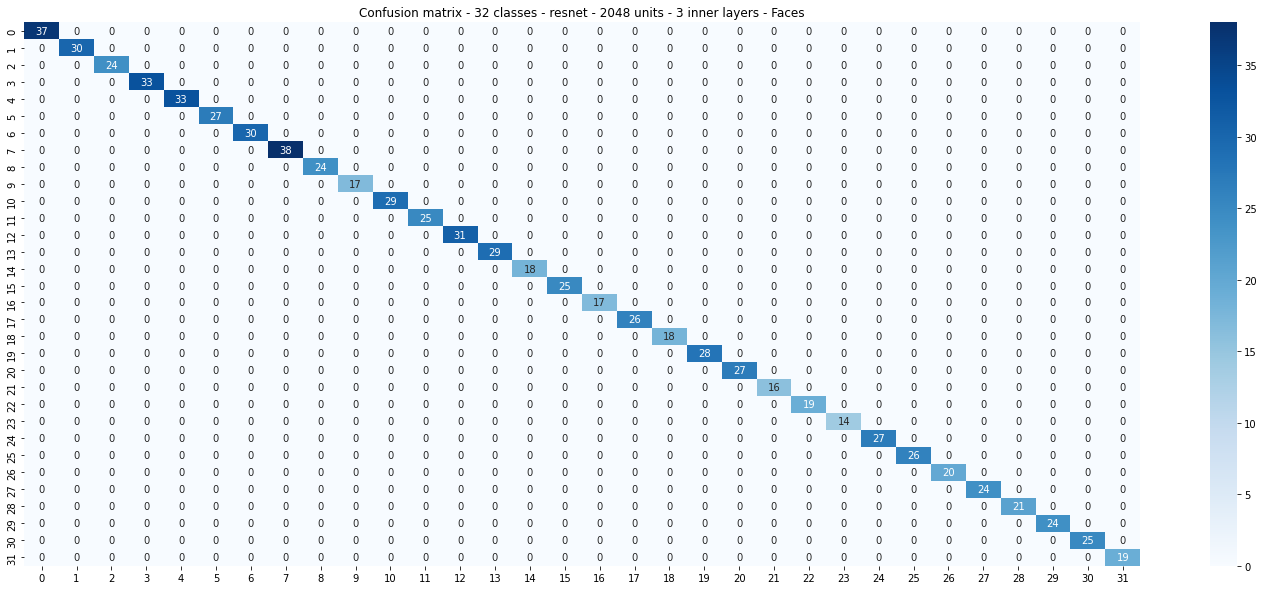

In [8]:
TFRECORD_PATH_EVA = f'./data/anime{"_faces" if USE_FACES else ""}_data_{EVA_CLASS}.tfrecord'
tf_record_eva = load_tfrecord_dataset(TFRECORD_PATH_EVA, SIZE_IMG)

all_ds_len = sum(1 for _ in tf_record_eva)
n_train = int(all_ds_len * 0.8)
n_test = int(all_ds_len * 0.2)

tf_record_eva = tf_record_eva.shuffle(n_train + n_test, seed=SEED)
tf_record_eva = tf_record_eva.skip(n_train).take(n_test)
print(f'Total number of images or test: {n_test}')
tf_record_eva = tf_record_eva.batch(32)

all_preds = []
all_labels = []
for images, label in tf_record_eva:
  preds = model_eva.predict(images)
  all_labels.extend(label)
  all_preds.extend(np.argmax(preds, axis=1))
del tf_record_eva

confusion_matrix= tf.math.confusion_matrix(all_labels, all_preds, num_classes=EVA_CLASS)

plt.figure(figsize=(25, 10))
plt.title(f'Confusion matrix - {EVA_CLASS} classes - {EVA_TYPE} - {EVA_UNITS} units - {EVA_INNER} inner layers - {"Faces" if USE_FACES else ""}')
sns.heatmap(confusion_matrix.numpy(), annot=True, cmap='Blues')
plt.savefig(f'./metrics/confusion_matrix_{EVA_CLASS}_{EVA_TYPE}_{EVA_UNITS}_{EVA_INNER}_inner{SUFIX}.pdf')

##### Search vectors similarity

In [9]:
def cosine_similarity_cpu(a, b):
  return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def cosine_similarity_cpum(u, v):
  u_dot_v = np.sum(u*v,axis = 1)

  mod_u = np.sqrt(np.sum(u*u))
  mod_v = np.sqrt(np.sum(v*v,axis = 1))
  return 1 - u_dot_v/(mod_u*mod_v)

@tf.function
def cosine_similarity_tf(a, b):
  return tf.tensordot(a, b, axes=1) / (tf.norm(a) * tf.norm(b))

@tf.function
def cosine_similarity_tfm(u, v):
  u_dot_v = tf.reduce_sum(u*v,axis = 1)

  mod_u = tf.sqrt(tf.reduce_sum(u*u))
  mod_v = tf.sqrt(tf.reduce_sum(v*v,axis = 1))
  return 1 - u_dot_v/(mod_u*mod_v)

@numba.guvectorize(["void(float64[:], float64[:], float64[:])"], "(n),(n)->()", target='parallel', fastmath =True)
def fast_cosine_gufunc(u, v, result):
    m = u.shape[0]
    udotv = 0
    u_norm = 0
    v_norm = 0
    for i in range(m):
        if (np.isnan(u[i])) or (np.isnan(v[i])):
            continue

        udotv += u[i] * v[i]
        u_norm += u[i] * u[i]
        v_norm += v[i] * v[i]

    u_norm = np.sqrt(u_norm)
    v_norm = np.sqrt(v_norm)

    if (u_norm == 0) or (v_norm == 0):
        ratio = 1.0
    else:
        ratio = udotv / (u_norm * v_norm)
    result[:] = ratio

@numba.jit(nopython=False, parallel=True)
def cosine_similarity_numba(u, v):
  uv = 0
  uu = 0
  vv = 0
  
  for i in range(u.shape[0]):
    uv += u[i]*v[i]
    uu += u[i]*u[i]
    vv += v[i]*v[i]
  cos_theta = 1
  
  if uu != 0 and vv != 0:
    cos_theta = uv / np.sqrt(uu*vv)
  return cos_theta

##### Build and get metrics

In [10]:
def parse_tfrecord_vec(tfrecord, size):
  x = tf.io.parse_single_example(tfrecord, {
    'image': tf.io.FixedLenFeature([], tf.string),
    'class_name': tf.io.FixedLenFeature([], tf.string),
  })
  x_train = tf.image.decode_jpeg(x['image'], channels=3)
  x_train = tf.image.resize(x_train, (size, size))
  x_train = preprocess_input(x_train, mode='tf')

  y_train = x['class_name']
  if y_train is None:
    y_train = ''

  return x_train, y_train

def load_tfrecord_dataset_vec(file_pattern, size):
  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  return dataset.map(lambda x: parse_tfrecord_vec(x, size))

def parse_record_vec(combination):
  item_1, item_2 = combination
  img_1, label_1 = item_1
  img_2, label_2 = item_2
  return (img_1, img_2, label_1 == label_2)


In [11]:
#TFRECORD_PATH_VEC = './data/anime_data_32.tfrecord'
TFRECORD_PATH_VEC = './data/anime_faces_data_32.tfrecord'
tf_record_vec = load_tfrecord_dataset_vec(TFRECORD_PATH_VEC, SIZE_IMG)

all_ds_len = sum(1 for _ in tf_record_vec)

n_train = int(all_ds_len * 0.95)
n_test = int(all_ds_len * 0.05)

tf_record_vec = tf_record_vec.shuffle(n_train + n_test, seed=SEED)
tf_record_vec = tf_record_vec.skip(n_train).take(n_test)
print(f'Total number of images or test: {n_test}')

all_combinations = list(itertools.combinations(tf_record_vec, 2))

all_combinations = list(map(parse_record_vec, all_combinations))
rd.shuffle(all_combinations)
del tf_record_vec

Total number of images or test: 200


In [12]:
def calculate_cosine_similarity(combinations, model):
  result = []
  for idx, item in enumerate(combinations):
    img_1, img_2, label = item
    pred_1, pred_2 = model.vectorize(np.array([img_1, img_2]))
    #cos_sim = cosine_similarity_cpu(pred_1, pred_2)
    pred_1 = np.array(pred_1)
    pred_2 = np.array(pred_2)
    cos_sim = cosine_similarity_numba(pred_1, pred_2)
    result.append((cos_sim, label))
    #print(f'{idx + 1}/{len(combinations)} - {round(((idx + 1) / len(combinations)) * 100, 2)}%')
  return result

result = calculate_cosine_similarity(all_combinations[:MAX_VEC_LEN], model_eva)

In [13]:
df = pd.DataFrame(result)
df.columns = ['cos_sim', 'label']
df.label = df.label.astype(bool)

current_f1 = -1
metrics = {}
for threshold in range(0, 100, 1):
  pred_label = df.apply(lambda x: True if x.cos_sim > (threshold/100) else False, axis=1)
  precision_result = sk_metrics.precision_score(df.label, pred_label) # Impact when the model predict to lot False positives
  recall_result = sk_metrics.recall_score(df.label, pred_label) # Impact when the model predict to lot False negatives
  f1_result = sk_metrics.f1_score(df.label, pred_label) # Impact when the model predict to lot False positives and False negatives
  if f1_result > current_f1:
    current_f1 = f1_result
    metrics['precision'] = precision_result
    metrics['recall'] = recall_result
    metrics['f1'] = f1_result
    metrics['threshold'] = threshold / 100

print(metrics)
json.dump(metrics, open(f'./metrics/metrics_{EVA_CLASS}_{EVA_TYPE}_{EVA_UNITS}_{EVA_INNER}_inner{SUFIX}.json', 'w'))

{'precision': 1.0, 'recall': 0.9646017699115044, 'f1': 0.9819819819819819, 'threshold': 0.41}


##### Create embeddings with Faiss

In [ ]:
#TFRECORD_PATH_VEC = './data/anime_data_32.tfrecord'
TFRECORD_PATH_VEC = './data/anime_faces_data_32.tfrecord'
tf_record_vec = load_tfrecord_dataset_vec(TFRECORD_PATH_VEC, SIZE_IMG)

all_ds_len = tf_record_vec.reduce(0, lambda x,_: x+1).numpy()
LEN_TF_RECORD = all_ds_len if True else MAX_VEC_LEN
print(LEN_TF_RECORD)

tf_record_vec = tf_record_vec.take(LEN_TF_RECORD)
#tf_record_vec = tf_record_vec.shuffle(LEN_TF_RECORD, seed=SEED)

data_image = []
BATCH = 64
for idx, batch in enumerate(tf_record_vec.batch(BATCH)):
  imgs, class_names = batch
  pred_vecs = model_eva.vectorize(imgs)
  pred_vecs = pred_vecs.numpy().astype('float32')
  class_names = class_names.numpy().astype('str')
  data_image.extend(list(zip(pred_vecs, class_names)))
  print(f'{idx + 1}/{LEN_TF_RECORD // BATCH} - {round(((idx + 1) / (LEN_TF_RECORD // BATCH)) * 100, 2)}%')
  #img, class_name = item
  #pred_vec = model_eva.vectorize(np.array([img]))[0]
  #data_item = (
  #  pred_vec.numpy().astype('float32'),
  #  class_name.numpy().decode('utf-8')
  #)
  #data_image.append(data_item)
  #print(f'{idx + 1}/{LEN_TF_RECORD} - {round(((idx + 1) / LEN_TF_RECORD) * 100, 2)}%')

pkl.dump(np.array(data_image), open(f'./data/data_image_{all_ds_len}{SUFIX}.pkl', 'wb'))
del data_image

In [17]:
data_image = pkl.load(open(f'./data/data_image_{4007}{SUFIX}.pkl', 'rb'))
vector_images = np.array(list(data_image[:, 0])) 

d = 2048 #Shape of vector result: (2048,)
nb = 4007
res = faiss.StandardGpuResources()  # use a single GPU

# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)
gpu_index_flat.add(vector_images)
print(f'Vectors {gpu_index_flat.ntotal}')

Vectors 4007


In [ ]:
k = 20 # we want to see 4 nearest neighbors
idx_search = 670
print(f'Target: ', data_image[idx_search][1])

dimension_vec, ids_result = gpu_index_flat.search(vector_images[idx_search: idx_search + 1], k) # actual search

current_id = 1
result = {}
for idx, id_v in enumerate(ids_result[0]):
  class_name = data_image[id_v][1]
  if class_name not in result:
    result[class_name] = 0
  result[class_name] += 1

print(f'\nResult: {result}')
print(f'\nOnly name: {", ".join(list(result.keys()))}')

In [31]:
result[0:1].shape

(1, 2048)

In [21]:
k = 20 # we want to see 4 nearest neighbors
idx_search = 670
izumi = load_img("./images/unnamed.jpg", target_size=(224, 224))
izumi_2 = load_img("./images/izumi____98..png", target_size=(224, 224))
miyamura = load_img("./images/miyamura____127..png", target_size=(224, 224))
aika = load_img("./images/aika____10..png", target_size=(224, 224))

aika = np.array(aika)
izumi = np.array(izumi)
miyamura = np.array(miyamura)
izumi_2 = np.array(izumi_2)

images = preprocess_input(np.array([izumi, izumi_2, miyamura, aika]), mode='tf')

result = model_eva.vectorize(images)
result = result.numpy().astype('float32')

dimension_vec, ids_result = gpu_index_flat.search(result[0:1], k) # actual search

current_id = 1
result = {}
for idx, id_v in enumerate(ids_result[0]):
  class_name = data_image[id_v][1]
  if class_name not in result:
    result[class_name] = 0
  result[class_name] += 1

print(f'\nResult: {result}')
print(f'\nOnly name: {", ".join(list(result.keys()))}')


Result: {'sairenji': 1, 'alice': 6, 'yagami': 1, 'kousaka': 5, 'hiiragi': 1, 'horo': 1, 'ranka': 3, 'daidouji': 1, 'sonozaki': 1}

Only name: sairenji, alice, yagami, kousaka, hiiragi, horo, ranka, daidouji, sonozaki


##### Evalaute time TF vs Numba vs CPU

In [ ]:
db1 = load_img("./images/db1.jpg", target_size=(224, 224))
db2 = load_img("./images/db2.jpeg", target_size=(224, 224))
nr1 = load_img("./images/nr1.webp", target_size=(224, 224))
db1 = np.array(db1)
db2 = np.array(db2)
nr1 = np.array(nr1)

images = preprocess_input(np.array([db1, db2, nr1]), mode='tf')

results = model_16.predict(images)
iterations = 1000

cpu_r = []
start = time.time()
for i in range(iterations):
  tg_vector = results[0]
  cpu_r.append(cosine_similarity_cpum(tg_vector, results))
  #for reuslt in results:
  #  cpu_r.append(cosine_similarity_cpu(reuslt, reuslt))
end = time.time()
print(f'Time to compute on CPU: {end - start}')

numba_r = []
start = time.time()
for i in range(iterations):
  tg_vector = results[0]
  numba_r.append(fast_cosine_gufunc(results, tg_vector))
end = time.time()
print(f'Time to compute on Numba: {end - start}')

images_gpu = [tf.convert_to_tensor(result) for result in results]
tf_r = []
start = time.time()
for i in range(iterations):
  tg_vector = images_gpu[0]
  tf_r.append(cosine_similarity_tfm(tg_vector, results))
  #for reuslt in images_gpu:
  #  tf_r.append(cosine_similarity_tf(result, images_gpu[0]))
end = time.time()
print(f'Time to compute on TF: {end - start}')

In [ ]:
model = AnimeClassifier(
  num_classes=len(class_array),
  input_shape=(SIZE_IMG, SIZE_IMG, 3),
  type_extractor='vgg',
  units=UNITS,
  inner_layers=1
)
model.build(input_shape=(None, SIZE_IMG, SIZE_IMG, 3))
PATH_BEST = './models/vgg_16class_1024_units_aqr.h5'
model.load_weights(PATH_BEST)
model.summary()

### Calculate vector and similarity

In [14]:
db1 = load_img("./images/db1.jpg", target_size=(224, 224))
db2 = load_img("./images/db2.jpeg", target_size=(224, 224))
nr1 = load_img("./images/nr1.webp", target_size=(224, 224))
izumi = load_img("./images/izumi____110..png", target_size=(224, 224))
izumi_2 = load_img("./images/izumi____98..png", target_size=(224, 224))
miyamura = load_img("./images/miyamura____127..png", target_size=(224, 224))
aika = load_img("./images/aika____10..png", target_size=(224, 224))
aika_ext = load_img("./images/Aika_Teen.webp", target_size=(224, 224))

aika = np.array(aika)
izumi = np.array(izumi)
miyamura = np.array(miyamura)
izumi_2 = np.array(izumi_2)
aika_ext = np.array(aika_ext)

images = preprocess_input(np.array([izumi, izumi_2, miyamura, aika, aika_ext]), mode='tf')

izumi_v, izumi_2_v, miyamura_v, aika_v, aika_ext_v= model_eva.vectorize(images)
print(f'Shape of vectors: {izumi_v.shape}')

Shape of vectors: (2048,)


In [15]:
cosine_similarity_numba(np.array(aika_ext_v), np.array(aika_v))

0.4849376190871775

In [ ]:
cosine_similarity_numba(np.array(db1_v), np.array(db2_v))